In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.prior import Prior
from sklearn.preprocessing import MinMaxScaler
import pymc as pm
import arviz as az

warnings.filterwarnings("ignore",category=FutureWarning)

## Data

In [3]:
data = pd.read_csv("../data/data1.csv",delimiter=',')
media_columns=["TikTok","Facebook","Google Ads"]

In [6]:
mmm_default = MMM.load("mmm_1.nc")

### Budget optimization

In [7]:
perc_change =0.2
budget_len =12
budget_idx = slice(len(data)-budget_len,len(data))

recent_period = data[budget_idx][media_columns]
recent_period

,TikTok,Facebook,Google Ads
188,8520.87,0.00,0.00
189,13086.03,0.00,2094.45
190,7414.29,0.00,2186.08
191,10534.10,0.00,1964.94
192,0.00,5213.48,1715.62
193,7663.81,0.00,2399.59
194,0.00,4757.98,0.00
195,0.00,0.00,1691.68
196,11543.58,4615.35,2518.88
197,0.00,4556.16,1919.19


In [8]:
budget = 10000#round(recent_period.sum(axis=0).sum()/budget_len , -3)

current_budget_split = round(recent_period.mean()/recent_period.mean().sum(),2)

lower_bound = round(recent_period.min(axis=0)*(1-perc_change),2)
upper_bound = round(recent_period.max(axis=0)*(1+perc_change),2)

budget_bounds = {col : [lower_bound[col],upper_bound[col]]
                 for col in media_columns}

print(f'Overall budget constraint: {budget}')
print('Channel constraints:')
for channel, bounds in budget_bounds.items():
    print(f'  {channel}: Lower Bound = {bounds[0]}, Upper Bound = {bounds[1]}')

Overall budget constraint: 10000
Channel constraints:
  TikTok: Lower Bound = 0.0, Upper Bound = 15703.24
  Facebook: Lower Bound = 0.0, Upper Bound = 6256.18
  Google Ads: Lower Bound = 0.0, Upper Bound = 3022.66


In [9]:
model_granularity = "weekly"

allocation_strategy, optimization_result = mmm_default.optimize_budget(
    budget=budget,
    budget_bounds=budget_bounds,
    num_periods=budget_len,
    minimize_kwargs={
        "method":"SLSQP",
        "options":{"ftol":1e-09,"maxiter":5_000},
    }
)

response = mmm_default.sample_response_distribution(
    allocation_strategy=allocation_strategy,
    time_granularity = model_granularity,
    num_periods=budget_len,
    noise_level=0.05
)


/usr/local/anaconda3/envs/datascience/lib/python3.10/site-packages/pymc_marketing/mmm/budget_optimizer.py:227: UserWarning: Using default equality constraint
  self.set_constraints(
Sampling: [y]


In [10]:
opt_spend = pd.Series(allocation_strategy, index=recent_period.mean().index).to_frame(name="opt_spend")
opt_spend["avg_spend"] = budget * current_budget_split
opt_spend

,opt_spend,avg_spend
TikTok,721.16,6000.0
Facebook,6256.18,2000.0
Google Ads,3022.66,2000.0


In [11]:
opt_spend.sum()

opt_spend    10000.0
avg_spend    10000.0
dtype: float64

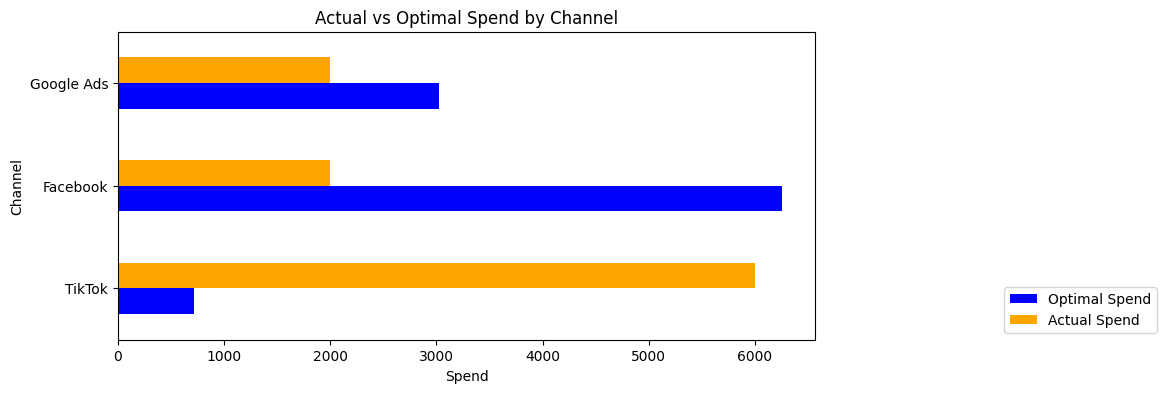

In [12]:
fig, ax = plt.subplots(figsize=(9, 4))
opt_spend.plot(kind='barh', ax=ax, color=['blue', 'orange'])

plt.xlabel("Spend")
plt.ylabel("Channel")
plt.title("Actual vs Optimal Spend by Channel")
plt.legend(["Optimal Spend", "Actual Spend"])
plt.legend(["Optimal Spend", "Actual Spend"], loc='lower right', bbox_to_anchor=(1.5, 0.0))

plt.show()

In [13]:
mmm_default.X['Date']

index
0     2018-01-07
1     2018-01-14
2     2018-01-21
3     2018-01-28
4     2018-02-04
         ...    
187   2021-08-08
188   2021-08-15
189   2021-08-22
190   2021-08-29
191   2021-09-05
Name: Date, Length: 192, dtype: datetime64[ns]

In [14]:
# create dataframe with optimal spend
last_date = mmm_default.X['Date'].max()
new_dates = pd.date_range(start=last_date, periods=1 + budget_len, freq="W-MON")[1:]
budget_scenario_opt = pd.DataFrame({"Date": new_dates,})
budget_scenario_opt["TikTok"] = opt_spend["opt_spend"]["TikTok"]
budget_scenario_opt["Facebook"] = opt_spend["opt_spend"]["Facebook"]
budget_scenario_opt["Google Ads"] = opt_spend["opt_spend"]["Google Ads"]
# budget_scenario_opt["demand"] = X[budget_idx][control_cols].mean()[0]

# calculate overall contribution
scenario_contrib_opt = mmm_default.sample_posterior_predictive(
    X_pred=budget_scenario_opt, extend_idata=False
)

opt_contrib = scenario_contrib_opt.mean(dim="sample").sum()["y"].values


Sampling: [y]


Output()

In [15]:
# create dataframe with avg spend
last_date = mmm_default.X["Date"].max()
new_dates = pd.date_range(start=last_date, periods=1 + budget_len, freq="W-MON")[1:]
budget_scenario_avg = pd.DataFrame({"Date": new_dates,})
budget_scenario_avg["TikTok"] = opt_spend["avg_spend"]["TikTok"]
budget_scenario_avg["Facebook"] = opt_spend["avg_spend"]["Facebook"]
budget_scenario_avg["Google Ads"] = opt_spend["avg_spend"]["Google Ads"]
# budget_scenario_avg["demand"] = X[budget_idx][control_cols].mean()[0]

# calculate overall contribution
scenario_contrib_avg  = mmm_default.sample_posterior_predictive(
    X_pred=budget_scenario_avg , extend_idata=False
)

avg_contrib = scenario_contrib_avg.mean(dim="sample").sum()["y"].values

Sampling: [y]


Output()

In [17]:
print(f'% increase in sales: {round((opt_contrib / avg_contrib) - 1,5)}')

% increase in sales: 0.00022


Though the model suggests a redistribution of allocated budget, it increases the sales only marginally.
